# 데이터 분석

1. `train, test 데이터의 Input 토큰 개수 분포 확인`
    - 전체 train, test 데이터에 대해 샘플별 Input 토큰 개수 확인
    - 전체 train, test 데이터에 대해 라벨별 Input 토큰 개수 확인
    - 최대 토큰 개수 (512)를 넘어가는 샘플 확인


2. `train, dev 분리`
    - 효과적인 분리를 위한 아이디어
    - 8:2로 train, dev 분리 및 저장
    - `python train_dev_split.py` 를 통해 간단하게 train, dev 분리 가능하도록 구현 


3. `분리된 train, dev Input 토큰 개수 분포 확인`
    - train, dev 데이터에 대해 샘플별 Input 토큰 개수 확인
    - train, dev 데이터에 대해 라벨별 Input 토큰 개수 확인

## train데이터의 Input 토큰 개수 분포 확인

### 전체 train 데이터에 대해 샘플 별 Input 토큰 개수 확인

- BertTokenizer와 RobertaTokenizer일때 비교

In [4]:
from transformers import (BertTokenizer, RobertaTokenizer,
                          BERT_PRETRAINED_CONFIG_ARCHIVE_MAP,
                          LAYOUTLM_PRETRAINED_CONFIG_ARCHIVE_MAP,
                          ROBERTA_PRETRAINED_CONFIG_ARCHIVE_MAP)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

MODEL_CLASSES = {
    "bert": BertTokenizer,
    "roberta": RobertaTokenizer,
    "layoutlm": BertTokenizer,
}

ALL_MODELS = sum(
    (
        tuple(conf_archive_map.keys())
        for conf_archive_map in (
            BERT_PRETRAINED_CONFIG_ARCHIVE_MAP,
            ROBERTA_PRETRAINED_CONFIG_ARCHIVE_MAP,
            LAYOUTLM_PRETRAINED_CONFIG_ARCHIVE_MAP,
        )
    ),
    (),
)

train_df, test_df = pd.read_csv('train.csv'), pd.read_csv('test.csv')

In [16]:
# Model you can use
list(ALL_MODELS)

['bert-base-uncased',
 'bert-large-uncased',
 'bert-base-cased',
 'bert-large-cased',
 'bert-base-multilingual-uncased',
 'bert-base-multilingual-cased',
 'bert-base-chinese',
 'bert-base-german-cased',
 'bert-large-uncased-whole-word-masking',
 'bert-large-cased-whole-word-masking',
 'bert-large-uncased-whole-word-masking-finetuned-squad',
 'bert-large-cased-whole-word-masking-finetuned-squad',
 'bert-base-cased-finetuned-mrpc',
 'bert-base-german-dbmdz-cased',
 'bert-base-german-dbmdz-uncased',
 'cl-tohoku/bert-base-japanese',
 'cl-tohoku/bert-base-japanese-whole-word-masking',
 'cl-tohoku/bert-base-japanese-char',
 'cl-tohoku/bert-base-japanese-char-whole-word-masking',
 'TurkuNLP/bert-base-finnish-cased-v1',
 'TurkuNLP/bert-base-finnish-uncased-v1',
 'wietsedv/bert-base-dutch-cased',
 'roberta-base',
 'roberta-large',
 'roberta-large-mnli',
 'distilroberta-base',
 'roberta-base-openai-detector',
 'roberta-large-openai-detector',
 'microsoft/layoutlm-base-uncased',
 'microsoft/layou

In [150]:
def input_length_analysis_per_sample(model_type, model_name_or_path, train_df, test_df, dev_df=None, do_lowercase=True, mode='test'):
    # load tokenizer
    tokenizer = MODEL_CLASSES[model_type].from_pretrained(model_name_or_path, do_lower_case=do_lowercase)

    dfs = {'train': train_df, 'test': test_df, 'dev': dev_df}

    # concat all text for each file
    for key, value in dfs.items():
        if value is not None:
            value['text'] = value['text'].astype(str)
            dfs[key] = value.groupby('file_name').agg({'text': ' '.join}).reset_index()
    
    # Tokenize the text
    for key, value in dfs.items():
        if value is not None:
            dfs[key] = value['text'].apply(lambda x: len(tokenizer.tokenize(x)) if type(x) is str else [])

    # Statistics of tokenized text length
    for key, value in dfs.items():
        if value is not None:
            print('[Statistics of tokenized text length by *{} tokenizer]'.format(model_type))
            print(' ({} set)'.format(key), ': Max length: {} |'.format(value.max()), 'Mean length: {:.2f} |'.format(value.mean()), 'Median length: {}'.format(value.median()))
        

    # Plot the distribution of the tokenized text
    colors = ['blue', 'red', 'green']

    plt.figure(figsize=(8, 4))
    for idx, (key, value) in enumerate(dfs.items()):
        if value is not None:
            sns.histplot(value, bins=50, color=colors[idx], kde=True, alpha=0.5, edgecolor='white')
    
    if mode=='test':
        plt.legend(['train', 'test'])
    else:
        
        plt.legend(['train', 'test', 'dev'])

    # Remove the top and right spines from plot
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    plt.title('Tokenized text length distribution by *{} tokenizer'.format(model_type), fontsize=15)
    plt.xlabel('Tokenized text length')
    plt.ylabel('Frequency')
    plt.show()

    return dfs.values()

[Statistics of tokenized text length by *bert tokenizer]
 (train set) : Max length: 68 | Mean length: 41.90 | Median length: 41.0
[Statistics of tokenized text length by *bert tokenizer]
 (test set) : Max length: 61 | Mean length: 40.83 | Median length: 40.0


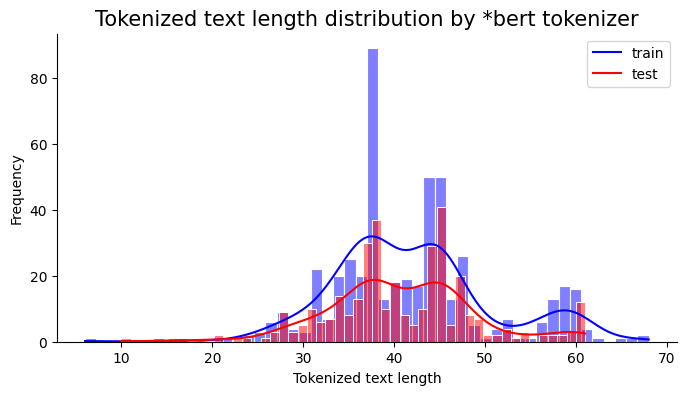

In [151]:
_, _, _ = input_length_analysis_per_sample('bert','google-bert/bert-base-uncased',train_df, test_df)

[Statistics of tokenized text length by *roberta tokenizer]
 (train set) : Max length: 89 | Mean length: 53.28 | Median length: 54.0
[Statistics of tokenized text length by *roberta tokenizer]
 (test set) : Max length: 79 | Mean length: 52.23 | Median length: 52.0


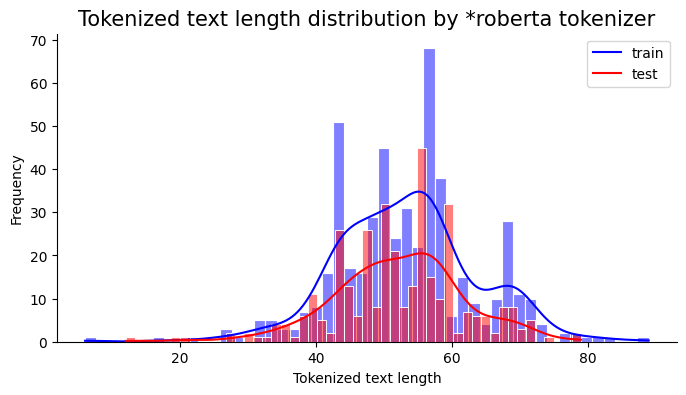

In [152]:
_, _, _ = input_length_analysis_per_sample('roberta','FacebookAI/roberta-large',train_df, test_df)

### 전체 train, test 데이터에 대해 라벨별 Input 토큰 개수 확인

In [129]:
#전체 train, test 데이터에 대해 라벨별 Input 토큰 개수 확인
def input_length_analysis_per_label(model_type,model_name_or_path,train_df, test_df,do_lowercase=True, mode='test'):
    # load tokenizer
    tokenizer = MODEL_CLASSES[model_type].from_pretrained(model_name_or_path, do_lower_case=do_lowercase)

    train_df['text'] = train_df['text'].astype(str)
    test_df['text'] = test_df['text'].astype(str)

    label_dict = {'company':0, 'address':1, 'date':2, 'total':3}
    
    # Tokenize the text
    for key in label_dict:
        train_text_len_series = train_df[train_df['label']==key]['text'].apply(lambda x: len(tokenizer.tokenize(x) if type(x) is str else []))
        test_text_len_series = test_df[test_df['label']==key]['text'].apply(lambda x: len(tokenizer.tokenize(x) if type(x) is str else []))
        label_dict[key] = (train_text_len_series, test_text_len_series)
    

    # Calculate statistics
    for key in label_dict:
        print('[Statistics of tokenized "{}" text length by *{} tokenizer]'.format(key, model_type))
        print(' (Train set)', ': Max length: {} |'.format(label_dict[key][0].max()), 'Mean length: {:.2f} |'.format(label_dict[key][0].mean()), 'Median length: {}'.format(label_dict[key][0].median()))
        print(' (Test set) ', ': Max length: {} |'.format(label_dict[key][1].max()), 'Mean length: {:.2f} |'.format(label_dict[key][1].mean()), 'Median length: {}'.format(label_dict[key][1].median()), '\n')


    # Plot the distribution of the tokenized text by label using subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    for i, key in enumerate(label_dict):
        row = i // 2
        col = i % 2

        sns.histplot(label_dict[key][0], bins=50, color='blue', kde=True, alpha=0.5, edgecolor='white', ax=axes[row, col])
        sns.histplot(label_dict[key][1], bins=50, color='red', kde=True, alpha=0.5, edgecolor='white', ax=axes[row, col])

        if mode=='test':
            axes[row, col].legend(['train', 'test'])
        else:
            axes[row, col].legend(['train', 'dev'])

        # Remove the top and right spines from plot
        axes[row, col].spines['top'].set_visible(False)
        axes[row, col].spines['right'].set_visible(False)

        axes[row, col].set_title('Tokenized [{}] text length distribution by *{} tokenizer'.format(key, model_type), fontsize=13)
        axes[row, col].set_xlabel('Tokenized text length')
        axes[row, col].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

    return train_text_len_series, test_text_len_series

[Statistics of tokenized "company" text length by *bert tokenizer]
 (Train set) : Max length: 17 | Mean length: 8.40 | Median length: 9.0
 (Test set)  : Max length: 19 | Mean length: 8.22 | Median length: 8.0 

[Statistics of tokenized "address" text length by *bert tokenizer]
 (Train set) : Max length: 46 | Mean length: 25.47 | Median length: 25.0
 (Test set)  : Max length: 42 | Mean length: 24.70 | Median length: 25.0 

[Statistics of tokenized "date" text length by *bert tokenizer]
 (Train set) : Max length: 10 | Mean length: 4.84 | Median length: 5.0
 (Test set)  : Max length: 6 | Mean length: 4.68 | Median length: 5.0 

[Statistics of tokenized "total" text length by *bert tokenizer]
 (Train set) : Max length: 6 | Mean length: 3.19 | Median length: 3.0
 (Test set)  : Max length: 5 | Mean length: 3.23 | Median length: 3.0 



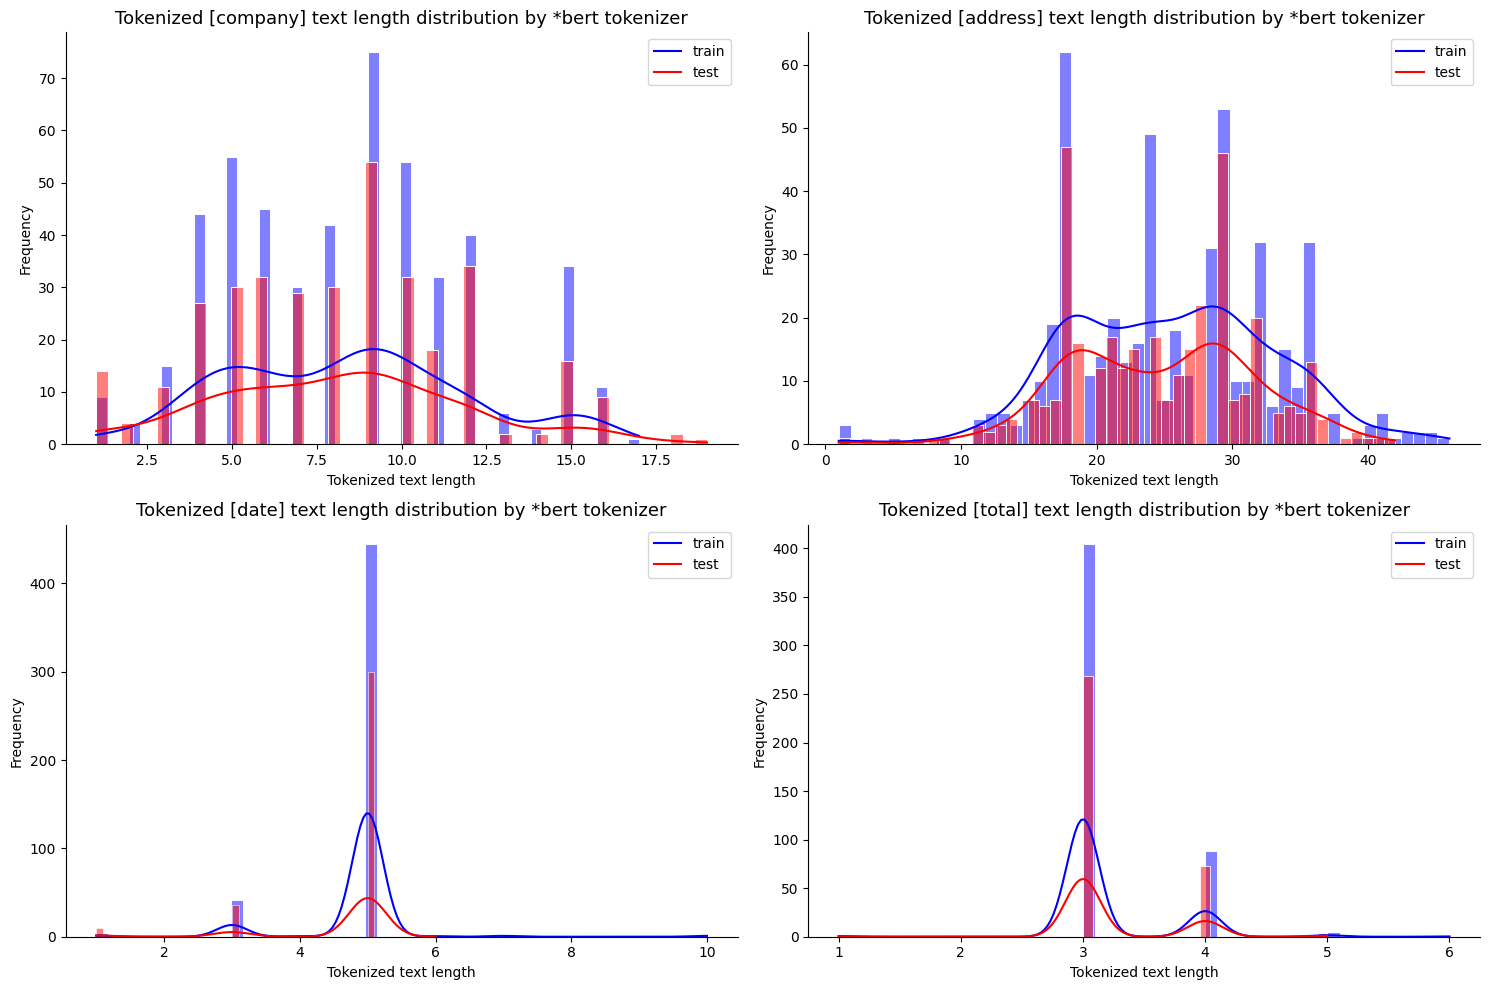

In [130]:
_, _ = input_length_analysis_per_label('bert','google-bert/bert-base-uncased',train_df, test_df)

[Statistics of tokenized "company" text length by *roberta tokenizer]
 (Train set) : Max length: 24 | Mean length: 11.32 | Median length: 11.0
 (Test set)  : Max length: 25 | Mean length: 11.14 | Median length: 11.0 

[Statistics of tokenized "address" text length by *roberta tokenizer]
 (Train set) : Max length: 66 | Mean length: 34.21 | Median length: 34.0
 (Test set)  : Max length: 60 | Mean length: 33.45 | Median length: 33.0 

[Statistics of tokenized "date" text length by *roberta tokenizer]
 (Train set) : Max length: 10 | Mean length: 4.88 | Median length: 5.0
 (Test set)  : Max length: 6 | Mean length: 4.75 | Median length: 5.0 

[Statistics of tokenized "total" text length by *roberta tokenizer]
 (Train set) : Max length: 6 | Mean length: 3.16 | Median length: 3.0
 (Test set)  : Max length: 4 | Mean length: 3.20 | Median length: 3.0 



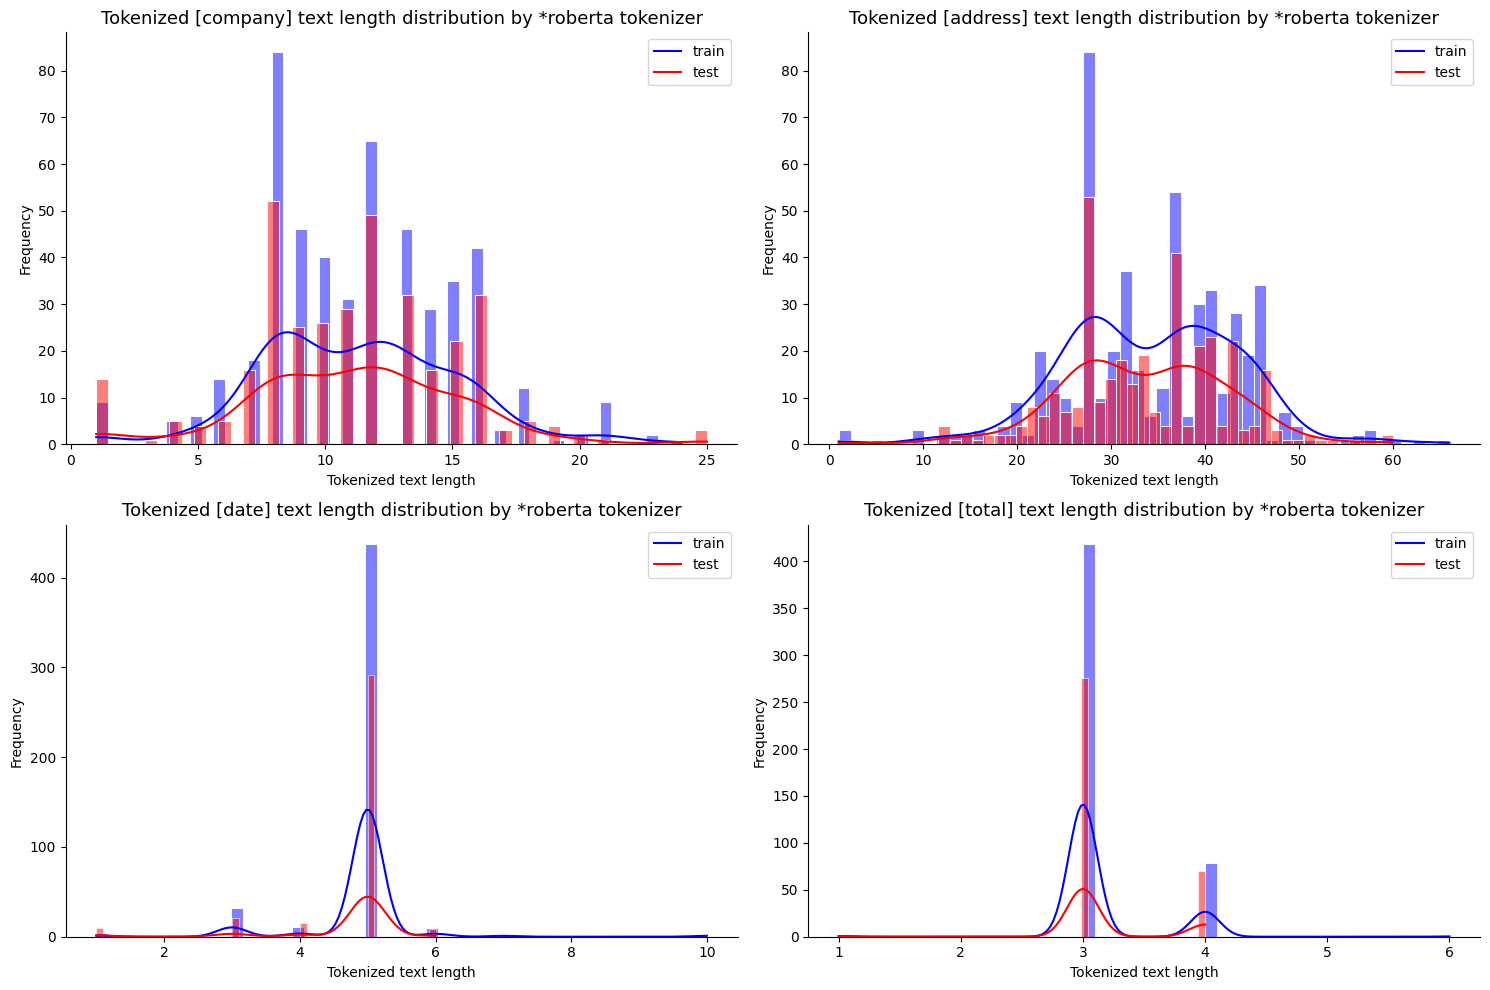

In [131]:
_, _ = input_length_analysis_per_label('roberta','FacebookAI/roberta-large',train_df, test_df)

## train, dev 분리

### 효과적인 분리를 위한 아이디어

- `Dev와 Test의 분포가 같아야 한다`\
    → Dev와 Test의 라벨별 Input 토큰 개수 분포가 비슷하도록 구성\
    → 현재 Train과 Test의 분포가 비슷한 것을 확인\
    → 랜덤 샘플링으로 train, dev 분리

- `적절한 Dev 크기`\
    → train 데이터 개수(626)가 작아 검증의 신뢰성을 높이기 위해 train:dev 비율을 [9:1]이 아닌 [8:2]로 선정
    
- `모델 배포 이후 적용되는 현실의 데이터와 Dev, Test 데이터의 분포가 같아야 한다`\
    → 지금 해결할 수 있는 문제가 아님

- `python train_dev_split.py` 를 통해 간단하게 train, dev 분리 가능하도록 구현 

In [104]:
import os
import random

In [99]:
class InputExample(object):
    """A single training/test example for token classification."""

    def __init__(self, guid, words, labels, boxes, actual_bboxes, file_name, page_size):
        """Constructs a InputExample.

        Args:
            guid: Unique id for the example.
            words: list. The words of the sequence.
            labels: (Optional) list. The labels for each word of the sequence. This should be
            specified for train and dev examples, but not for test examples.
            boxes: (Optional) list. The bounding boxes of the words in the sequence.
            actual_bboxes: (Optional) list. The actual bounding boxes of the words in the sequence.
            file_name: (Optional) str. The name of the file.
            page_size: (Optional) list. The size of the page.
        """
        self.guid = guid
        self.words = words
        self.labels = labels
        self.boxes = boxes
        self.actual_bboxes = actual_bboxes
        self.file_name = file_name
        self.page_size = page_size


def read_examples_from_file(data_dir, mode):
    file_path = os.path.join(data_dir, "{}.txt".format(mode))
    box_file_path = os.path.join(data_dir, "{}_box.txt".format(mode))
    image_file_path = os.path.join(data_dir, "{}_image.txt".format(mode))
    guid_index = 1
    examples = []
    with open(file_path, encoding="utf-8") as f, open(
        box_file_path, encoding="utf-8"
    ) as fb, open(image_file_path, encoding="utf-8") as fi:
        words = []
        boxes = []
        actual_bboxes = []
        file_name = None
        page_size = None
        labels = []
        for line, bline, iline in zip(f, fb, fi):
            if line.startswith("-DOCSTART-") or line == "" or line == "\n":
                if words:
                    examples.append(
                        InputExample(
                            guid="{}-{}".format(mode, guid_index),
                            words=words,
                            labels=labels,
                            boxes=boxes,
                            actual_bboxes=actual_bboxes,
                            file_name=file_name,
                            page_size=page_size,
                        )
                    )
                    guid_index += 1
                    words = []
                    boxes = []
                    actual_bboxes = []
                    file_name = None
                    page_size = None
                    labels = []
            else:
                splits = line.split("\t") # [word, label]
                bsplits = bline.split("\t") # [word, box]
                isplits = iline.split("\t") # [word, actual_bbox, page_size, file_name]
                assert len(splits) == 2
                assert len(bsplits) == 2
                assert len(isplits) == 4
                assert splits[0] == bsplits[0]
                words.append(splits[0])
                if len(splits) > 1:
                    labels.append(splits[-1].replace("\n", ""))
                    box = bsplits[-1].replace("\n", "")
                    box = [int(b) for b in box.split()]
                    boxes.append(box)
                    actual_bbox = [int(b) for b in isplits[1].split()]
                    actual_bboxes.append(actual_bbox)
                    page_size = [int(i) for i in isplits[2].split()]
                    file_name = isplits[3].strip()
                else:
                    # Examples could have no label for mode = "test"
                    labels.append("O")
        if words: # if file does not end with a newline
            examples.append(
                InputExample(
                    guid="%s-%d".format(mode, guid_index),
                    words=words,
                    labels=labels,
                    boxes=boxes,
                    actual_bboxes=actual_bboxes,
                    file_name=file_name,
                    page_size=page_size,
                )
            )
    return examples

In [108]:
train_examples = read_examples_from_file("../data", "train")

### train, dev [8:2] 랜덤 샘플링

In [109]:
# shuffle
random.Random(42)
random.shuffle(train_examples)
print("Number of training examples:", len(train_examples))

# split train and validation 8:2
train_size = int(0.8 * len(train_examples))
train_set = train_examples[:train_size]
val_set = train_examples[train_size:]

print("Number of training set:", len(train_set))
print("Number of validation set:", len(val_set))

Number of training examples: 626
Number of training set: 500
Number of validation set: 126


In [111]:
# make new_train.txt, new_train_box.txt, new_train_image.txt and dev.txt, dev_box.txt, dev_image.txt
def write_examples_to_file(examples, mode):
    with open(f"{mode}.txt", "w", encoding="utf-8") as f, open(
        f"{mode}_box.txt", "w", encoding="utf-8"
    ) as fb, open(f"{mode}_image.txt", "w", encoding="utf-8") as fi:
        for example in examples:
            for word, label, box, actual_bbox in zip(
                example.words, example.labels, example.boxes, example.actual_bboxes
            ):
                f.write(f"{word}\t{label}\n")
                fb.write(f"{word}\t{' '.join([str(b) for b in box])}\n")
                fi.write(
                    f"{word}\t{' '.join([str(b) for b in actual_bbox])}\t{' '.join([str(i) for i in example.page_size])}\t{example.file_name}\n"
                )
            f.write("\n")
            fb.write("\n")
            fi.write("\n")

In [114]:
write_examples_to_file(train_set, "new_train")
write_examples_to_file(val_set, "dev")

## 분리된 train, dev, test Input 토큰 개수 분포 확인

### train, dev, test 데이터에 대해 샘플별 Input 토큰 개수 확인

In [136]:
train_df = pd.read_csv('new_train.csv')
dev_df = pd.read_csv('dev.csv')
test_df = pd.read_csv('test.csv')

[Statistics of tokenized text length by *bert tokenizer]
 (train set) : Max length: 68 | Mean length: 41.90 | Median length: 41.0
[Statistics of tokenized text length by *bert tokenizer]
 (test set) : Max length: 61 | Mean length: 40.83 | Median length: 40.0
[Statistics of tokenized text length by *bert tokenizer]
 (dev set) : Max length: 63 | Mean length: 42.17 | Median length: 42.0


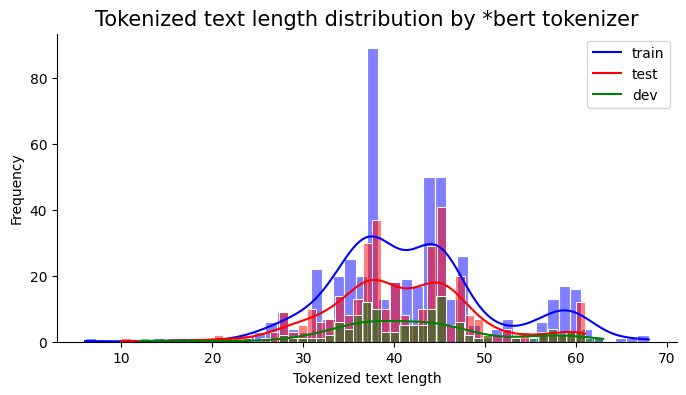

In [154]:
_, _, _ = input_length_analysis_per_sample('bert','google-bert/bert-base-uncased',train_df, test_df, dev_df, mode='dev')

[Statistics of tokenized text length by *roberta tokenizer]
 (train set) : Max length: 89 | Mean length: 53.28 | Median length: 54.0
[Statistics of tokenized text length by *roberta tokenizer]
 (test set) : Max length: 79 | Mean length: 52.23 | Median length: 52.0
[Statistics of tokenized text length by *roberta tokenizer]
 (dev set) : Max length: 72 | Mean length: 53.17 | Median length: 54.0


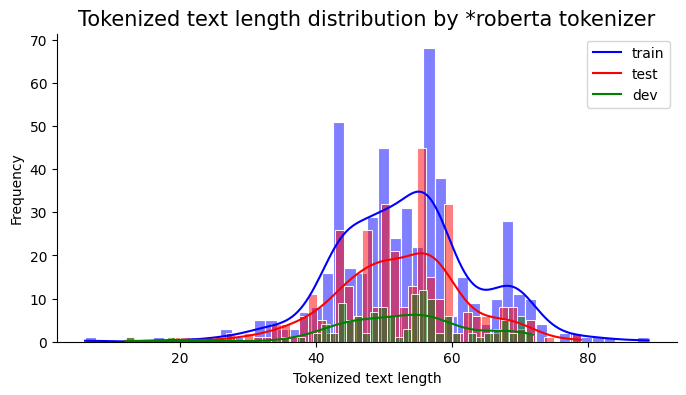

In [156]:
_, _, _ = input_length_analysis_per_sample('roberta','FacebookAI/roberta-large',train_df, test_df, dev_df, mode='dev')